## Hello!

This is an attempt to predict the winner of an NHL game given the NHL database given by Kaggle [here](https://www.kaggle.com/martinellis/nhl-game-data). After playing around with the data a lot, I found that home ice advantage played a role in the outcome of the game (home wins about 55% of the time). I looked into the head-to-head of each team vs. each other team and the results are found at this [imgur link](https://imgur.com/a/o316axx). After completing that, I wanted to find some feature that played a role in a team winning the game or not. Firstly, I mapped out where on the ice each team scored from the most, and where each team got scored on from the most - but this was not useful enough. Then, in this file, I checked the win rate if a team scores first - which was found to be useful and is explored below.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Read in csv's.
Need to replace team_id's because this database includes 33 teams (Phoenix and Atlanta had name changes to Arizona and Winnipeg)
which the database defaulted to calling team_id 52,53,54. I replace them to have team_id's go from 1-31


In [2]:

iter_gp_csv = pd.read_csv(r'C:\Users\SimoS\Documents\NHL\game_plays.csv', iterator = True, chunksize = 1000)
game_plays_df = pd.concat([chunk[(chunk.event == 'Goal')][['game_id','team_id_for', 'team_id_against', 'event']] for chunk in iter_gp_csv])
game_plays_df = game_plays_df.replace([52,53,54], [11,27,31])

#Only read in Regular Season games. Again, replace necessary team id's
iter_game_csv = pd.read_csv(r'C:\Users\SimoS\Documents\NHL\game.csv', iterator = True, chunksize = 1000)
game_df = pd.concat([chunk[(chunk.type == 'R')] for chunk in iter_game_csv])
game_df = game_df.replace([52,53,54], [11,27,31])

iter_gts_csv = pd.read_csv(r'C:\Users\SimoS\Documents\NHL\game_teams_stats.csv', iterator = True, chunksize = 1000)
game_teams_stats_df = pd.concat([chunk for chunk in iter_gts_csv])
game_teams_stats_df = game_teams_stats_df.replace([52,53,54], [11,27,31])

iter_team_csv = pd.read_csv(r'C:\Users\SimoS\Documents\NHL\team_info.csv', iterator = True, chunksize = 1000)
team_df = pd.concat([chunk for chunk in iter_team_csv])

Let's look at all the data frames to get some insight

In [3]:
game_plays_df.head(5)

,game_id,team_id_for,team_id_against,event
15,2011030221,1.0,4.0,Goal
133,2011030221,4.0,1.0,Goal
141,2011030221,4.0,1.0,Goal
161,2011030221,1.0,4.0,Goal
236,2011030221,4.0,1.0,Goal


In [4]:
game_df.head(5)

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
705,2013020674,20132014,R,2014-01-11,2014-01-11T03:00:00Z,19,23,1,2,home win REG,right,Rogers Arena,/api/v1/venues/null,America/Vancouver,-7,PDT
706,2013020177,20132014,R,2013-10-29,2013-10-29T23:00:00Z,24,4,3,2,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
707,2012020225,20122013,R,2013-02-19,2013-02-19T03:00:00Z,29,24,2,3,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT
708,2012020577,20122013,R,2013-04-08,2013-04-08T23:00:00Z,12,6,2,6,home win REG,left,TD Garden,/api/v1/venues/null,America/New_York,-4,EDT
709,2013021085,20132014,R,2014-03-25,2014-03-25T23:30:00Z,17,29,2,4,home win REG,left,Nationwide Arena,/api/v1/venues/null,America/New_York,-4,EDT


In [5]:
game_teams_stats_df.head(5)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
1,2011030221,4,home,True,OT,Peter Laviolette,4,36,27,6,6,1,55.1,13,4
2,2011030222,1,away,True,REG,Peter DeBoer,4,35,32,12,4,0,50.9,8,7
3,2011030222,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1


In [6]:
team_df.head(5)

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6


### List of functions to be used later on

In [7]:
"""
Return a complete, cleaned teamList
"""
def teamList():
    teamList = team_df[['team_id','shortName','teamName']][(team_df.team_id != 11) & (team_df.team_id != 27)].sort_values("shortName")
    teamList = teamList.replace([52,53,54],[11,27,31])
    return teamList
"""
Get the team name given teamID
"""
def getTeamName(userTeamID):
    x = teamList()
    teamName = x[(x.team_id == userTeamID)]
    teamName = teamName[['teamName']]
    return teamName.iloc[0][0]



### Example of what the functions do

In [8]:
teamList() 

,team_id,shortName,teamName
17,24,Anaheim,Ducks
31,27,Arizona,Coyotes
4,6,Boston,Bruins
22,7,Buffalo,Sabres
23,20,Calgary,Flames
30,12,Carolina,Hurricanes
11,16,Chicago,Blackhawks
24,21,Colorado,Avalanche
26,29,Columbus,Blue Jackets
25,25,Dallas,Stars


In [9]:
getTeamName(24)

'Ducks'

I want to see if scoring first in a game has any impact on the winner

In [10]:
#Get the first goal of each game
goals_df = game_plays_df
goals_df = goals_df.drop_duplicates("game_id") #Drop multiple goals in a game
score_first_df = goals_df.merge(game_teams_stats_df, on='game_id')
score_first_df = score_first_df[score_first_df.team_id_for == score_first_df.team_id]
score_first_df.head(10)

,game_id,team_id_for,team_id_against,event,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2011030221,1.0,4.0,Goal,1,away,False,OT,Peter DeBoer,3,26,31,12,3,1,44.9,6,7
3,2011030222,4.0,1.0,Goal,4,home,False,REG,Peter Laviolette,1,20,24,32,5,0,49.1,9,6
4,2011030223,4.0,1.0,Goal,4,away,False,OT,Peter Laviolette,3,28,28,4,5,1,50.8,2,1
6,2011030224,4.0,1.0,Goal,4,away,False,REG,Peter Laviolette,2,22,23,10,2,1,62.5,20,5
9,2011030225,4.0,1.0,Goal,4,home,False,REG,Peter Laviolette,1,28,38,8,1,0,45.0,14,7
10,2011030411,26.0,1.0,Goal,26,away,True,OT,Darryl Sutter,2,25,35,4,1,0,55.4,6,4
12,2011030412,26.0,1.0,Goal,26,away,True,OT,Darryl Sutter,2,32,32,8,2,0,53.5,1,3
15,2011030413,26.0,1.0,Goal,26,home,True,REG,Darryl Sutter,4,21,55,12,2,2,56.6,17,5
16,2011030414,1.0,26.0,Goal,1,away,True,REG,Peter DeBoer,3,24,43,8,3,0,31.0,13,2
19,2011030415,1.0,26.0,Goal,1,home,True,REG,Peter DeBoer,2,19,34,6,2,1,52.8,4,3


The above table shows every game played, and showing which team scored first.

In [11]:
#Get a cleaned team list (i.e team_id's are 1-31)
team_list = teamList()
team_df_modified = team_list[['team_id', 'shortName']]
team_df_modified

,team_id,shortName
17,24,Anaheim
31,27,Arizona
4,6,Boston
22,7,Buffalo
23,20,Calgary
30,12,Carolina
11,16,Chicago
24,21,Colorado
26,29,Columbus
25,25,Dallas


In [12]:
#See how many times each team scored first in the last 3 years (246 games). Merging with game_df eliminates playoff games.
score_first = pd.merge(score_first_df,game_df, on='game_id')[['game_id','team_id', 'HoA', 'won']]
score_first = score_first[((score_first.game_id.astype(str).str.startswith('2016'))
                            | (score_first.game_id.astype(str).str.startswith('2017')) 
                            | (score_first.game_id.astype(str).str.startswith('2018')))]
score_first.head(15)

,game_id,team_id,HoA,won
3125,2016020045,16,home,True
3126,2017020812,7,home,False
3129,2017020586,24,home,True
3130,2016020610,15,away,True
3132,2017020240,23,away,False
3133,2017020624,21,home,True
3135,2017020221,11,away,True
3136,2016020298,26,home,True
3137,2017020731,27,home,True
3138,2016020205,11,away,True


The above table shows which team scored first, whether the game was home or away, and whether they won or not, in the past 3 seasons.

### Let's see how many times each team scored first

In [13]:
score_first_count = score_first['team_id'].value_counts().reset_index()
score_first_count = score_first_count.rename(columns={'team_id':'score_first','index':'team_id'})
score_first_count = score_first_count.merge(team_df_modified, on='team_id')
score_first_count 

,team_id,score_first,shortName
0,5,140,Pittsburgh
1,16,138,Chicago
2,19,137,St Louis
3,29,137,Columbus
4,15,136,Washington
5,10,135,Toronto
6,28,129,San Jose
7,27,128,Arizona
8,6,128,Boston
9,11,127,Winnipeg


# Observe
- Vegas has the least because they have only existed for 2 seasons.
- Pittsburgh and Washington won the Stanley Cup in this time. Maybe scoring first does have impact

Let's see how often someone scores first and wins a game at home

In [14]:
home_wins_score_first = score_first[score_first.HoA == 'home']['won'].value_counts()
home_wins_score_first

True     1387
False     547
Name: won, dtype: int64

In [15]:
1387/(1387+547)

0.7171664943123061

# If a team scores first at home, they win 71.7% of the time

In [16]:
away_wins_score_first = score_first[score_first.HoA == 'away']['won'].value_counts()
away_wins_score_first

True     1120
False     674
Name: won, dtype: int64

In [17]:
1120/(1120+674)

0.6243032329988851

# If a team scores first away, they win 62.4% of the time
This plays into the role of home ice advantage. This is explored in another file which can be found in a kernel on Kaggle through the link at the start of this file.

Let's create a training set based on the variables of Home and Away, and scoring first.

In [18]:
#Create train set (2016-2017, 2017-2018, 2018-2019 seasons)
train = game_df[['game_id', 'home_team_id', 'away_team_id', 'outcome']]
train = train[((train.game_id.astype(str).str.startswith('2016'))\
               | (train.game_id.astype(str).str.startswith('2017'))\
               | (train.game_id.astype(str).str.startswith('2018')))]

In [19]:
train.head(10)

,game_id,home_team_id,away_team_id,outcome
3885,2016020045,16,4,home win REG
3886,2017020812,7,24,away win OT
3889,2017020586,24,20,home win REG
3890,2016020610,8,15,away win REG
3892,2017020240,24,23,home win REG
3893,2017020624,21,29,home win REG
3895,2017020221,25,11,away win REG
3896,2016020298,26,2,home win REG
3897,2017020731,27,2,home win OT
3898,2016020205,27,11,away win REG


For simplicity, we won't worry about REG vs OT vs SO wins, we will only care about if the home team won or if the away team won

In [20]:
train.loc[train.outcome.str.contains('home'), 'outcome'] = 1
train.loc[train.outcome.str.contains('away',na=False), 'outcome'] = 0
train.head(10)

,game_id,home_team_id,away_team_id,outcome
3885,2016020045,16,4,1
3886,2017020812,7,24,0
3889,2017020586,24,20,1
3890,2016020610,8,15,0
3892,2017020240,24,23,1
3893,2017020624,21,29,1
3895,2017020221,25,11,0
3896,2016020298,26,2,1
3897,2017020731,27,2,1
3898,2016020205,27,11,0


### Merge with the score first dataframe we made before

In [21]:
train = train.merge(score_first_count, left_on='home_team_id', right_on='team_id')
train['home_score_first'] = train['score_first'] / 246 #Divide by 256 games played over 3 seasons
train = train.drop(columns=['team_id','score_first','shortName'])
train.head(10)

,game_id,home_team_id,away_team_id,outcome,home_score_first
0,2016020045,16,4,1,0.560976
1,2017021255,16,19,0,0.560976
2,2016020178,16,25,1,0.560976
3,2016020139,16,20,1,0.560976
4,2016021067,16,21,1,0.560976
5,2016020917,16,19,1,0.560976
6,2017021040,16,12,0,0.560976
7,2017020181,16,4,1,0.560976
8,2016021152,16,29,1,0.560976
9,2017020718,16,2,0,0.560976


### I want to get the probability that the home team scores first, given the opponent they are playing. Need to find out how often away team scores first.

In [22]:
train = train.merge(score_first_count, left_on='away_team_id', right_on='team_id')
train['away_score_first'] = train['score_first'] / 246
train = train.drop(columns=['team_id','score_first','shortName'],axis=1)
train.head(10)

,game_id,home_team_id,away_team_id,outcome,home_score_first,away_score_first
0,2016020045,16,4,1,0.560976,0.406504
1,2017020181,16,4,1,0.560976,0.406504
2,2018021142,16,4,0,0.560976,0.406504
3,2017020539,7,4,1,0.471545,0.406504
4,2016020973,7,4,0,0.471545,0.406504
5,2016020613,7,4,1,0.471545,0.406504
6,2018020318,7,4,1,0.471545,0.406504
7,2018020444,7,4,0,0.471545,0.406504
8,2016020561,24,4,1,0.500000,0.406504
9,2017020029,24,4,0,0.500000,0.406504


### I want one number to represent how likely it is for the home team to score first. Take the home_score_first columna and divide it by (home_score_first + away_score_first) to get a percentage.
- Above 50% implies the home team has a higher chance to score first
- Below 50% implies the away team has a high chance to score first

In [23]:
train['%home_score_first'] = (train['home_score_first'] / (train['away_score_first'] + train['home_score_first']))
train.head(10)

,game_id,home_team_id,away_team_id,outcome,home_score_first,away_score_first,%home_score_first
0,2016020045,16,4,1,0.560976,0.406504,0.579832
1,2017020181,16,4,1,0.560976,0.406504,0.579832
2,2018021142,16,4,0,0.560976,0.406504,0.579832
3,2017020539,7,4,1,0.471545,0.406504,0.537037
4,2016020973,7,4,0,0.471545,0.406504,0.537037
5,2016020613,7,4,1,0.471545,0.406504,0.537037
6,2018020318,7,4,1,0.471545,0.406504,0.537037
7,2018020444,7,4,0,0.471545,0.406504,0.537037
8,2016020561,24,4,1,0.500000,0.406504,0.551570
9,2017020029,24,4,0,0.500000,0.406504,0.551570


In [24]:
y = train['outcome']
x1 = train['%home_score_first']

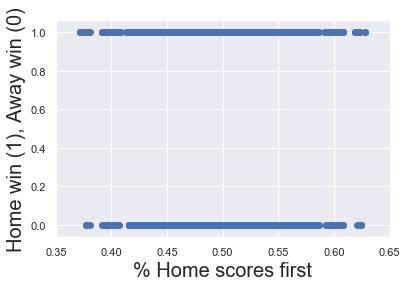

In [25]:
# Create a scatter plot of x1 (%home_score_first, no constant) and y (Outcome)
plt.scatter(x1,y, color='C0')
# Don't forget to label your axes!
plt.xlabel('% Home scores first', fontsize = 20)
plt.ylabel('Home win (1), Away win (0)', fontsize = 20)
plt.show()

### We can tell that there will not be an accurate regression curve, but we will continue for the purpose of making a prediction.

In [27]:
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm

In [28]:
train_1, test = train_test_split(train, test_size = 0.3)# in this our main data is split into trai

In [30]:
train_X = train_1[['home_team_id','away_team_id','%home_score_first']]
train_y = train_1.outcome

In [32]:
test_X=test[['home_team_id','away_team_id','%home_score_first']]

In [33]:
test_y = test.outcome

In [34]:
train_X.head(5)

,home_team_id,away_team_id,%home_score_first
1761,20,6,0.466667
2486,26,23,0.497297
3401,29,3,0.537255
1348,9,17,0.491071
2065,3,18,0.483607


In [35]:
test_X.head(5)

,home_team_id,away_team_id,%home_score_first
633,25,12,0.497959
595,19,21,0.554656
2166,10,11,0.515267
2520,2,23,0.573394
2953,16,13,0.522727


In [36]:
train_y.head(5)

1761    0
2486    0
3401    1
1348    1
2065    1
Name: outcome, dtype: int64

In [37]:
test_y.head(5)

633     1
595     1
2166    1
2520    1
2953    1
Name: outcome, dtype: int64

In [38]:
#Logistic regression
model = LogisticRegression()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction,test_y))

The accuracy of the Logistic Regression is 0.5706713780918727


c:\users\simos\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
#KNN
model=KNeighborsClassifier(n_neighbors=3) #this examines 3 neighbours for putting the new data into a class
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction,test_y))

The accuracy of the KNN is 0.5167844522968198


In [40]:
model = svm.SVC() #select the algorithm
model.fit(train_X,train_y) # we train the algorithm with the training data and the training output
prediction=model.predict(test_X) #now we pass the testing data to the trained algorithm
print('The accuracy of the SVM is:',metrics.accuracy_score(prediction,test_y))#now we check the accuracy of the algorithm. 
#we pass the predicted output by the model and the actual output

c:\users\simos\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The accuracy of the SVM is: 0.5468197879858657


### As we can tell, Logistic regression has the highest accuracy, which is still quite low at 57%
- This can clearly be seen by our graph plotted above. There is not a strong enough relationship between scoring first and the winner of a game. 

### This is an ongoing project - more variables will be incorporated to make this more accurate. The next variables to be explored are Head to Head stats as well as each teams previous 10 games records'